### IMPORT THE LIBRARIES

In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from IPython.display import Image

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

In [3]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

#### LOADING THE DATA

In [4]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,),
                                     std=(0.5,))])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

100%|████████████████████████████████████████████████████████████████████▉| 9912320/9912422 [02:27<00:00, 98994.70it/s]

Extracting ../../data/MNIST\raw\train-images-idx3-ubyte.gz to ../../data/MNIST\raw



0it [00:00, ?it/s]
  0%|                                                                                        | 0/28881 [00:00<?, ?it/s]
32768it [00:01, 26886.44it/s]                                                                                          


Extracting ../../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../../data/MNIST\raw



0it [00:00, ?it/s]
 98%|██████████████████████████████████████████████████████████████████▉ | 1622016/1648877 [00:10<00:00, 309445.62it/s]

Extracting ../../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/MNIST\raw




9920512it [02:40, 98994.70it/s]                                                                                        

  0%|                                                                                         | 0/4542 [00:01<?, ?it/s]

Extracting ../../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/MNIST\raw
Processing...
Done!


#### DEFINE THE MODELS

In [5]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1))

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [6]:
# Device setting
D = D.to(device)
G = G.to(device)


1654784it [00:20, 309445.62it/s]                                                                                       

In [7]:
# Optimizers
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [8]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [9]:
# Loss weight for gradient penalty
lambda_gp = 10

#### GRADIENT PENALTY

In [10]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0),1))).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

#### TRAINING THE MODEL

In [11]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        for di in range(5):
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            D_real = D(images)
            D_fake = D(fake_images)
          
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(D, images.data, fake_images.data)
        
            # Backprop and optimize
            d_loss = -(torch.mean(D_real) - torch.mean(D_fake)) + lambda_gp * gradient_penalty
          
            reset_grad()
            d_loss.backward()
            d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

            # Compute loss with fake images
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            D_fake = D(fake_images)
        
            g_loss = -torch.mean(D_fake)
        
            # Backprop and optimize
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
        
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          D_real.mean().item(), D_fake.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/200], Step [200/600], d_loss: -3.5706, g_loss: -2.1925, D(x): 6.22, D(G(z)): 2.19
Epoch [0/200], Step [200/600], d_loss: -3.3550, g_loss: -1.4999, D(x): 6.22, D(G(z)): 1.50
Epoch [0/200], Step [200/600], d_loss: -4.2027, g_loss: -2.0791, D(x): 6.03, D(G(z)): 2.08
Epoch [0/200], Step [200/600], d_loss: -3.7492, g_loss: -2.1091, D(x): 6.36, D(G(z)): 2.11
Epoch [0/200], Step [200/600], d_loss: -3.8439, g_loss: -1.9249, D(x): 6.52, D(G(z)): 1.92
Epoch [0/200], Step [400/600], d_loss: -4.0202, g_loss: 1.8915, D(x): 2.72, D(G(z)): -1.89
Epoch [0/200], Step [400/600], d_loss: -4.2475, g_loss: 1.9331, D(x): 3.03, D(G(z)): -1.93
Epoch [0/200], Step [400/600], d_loss: -4.3069, g_loss: 1.5355, D(x): 3.15, D(G(z)): -1.54
Epoch [0/200], Step [400/600], d_loss: -4.2213, g_loss: 1.5716, D(x): 3.20, D(G(z)): -1.57
Epoch [0/200], Step [400/600], d_loss: -4.4060, g_loss: 1.4866, D(x): 3.44, D(G(z)): -1.49
Epoch [0/200], Step [600/600], d_loss: -3.9036, g_loss: 4.1986, D(x): 0.95, D(G(z)): -4.20

Epoch [11/200], Step [600/600], d_loss: -1.2827, g_loss: -3.3722, D(x): 4.56, D(G(z)): 3.37
Epoch [12/200], Step [200/600], d_loss: -0.2567, g_loss: -1.9909, D(x): 2.12, D(G(z)): 1.99
Epoch [12/200], Step [200/600], d_loss: -0.4196, g_loss: -2.4389, D(x): 2.38, D(G(z)): 2.44
Epoch [12/200], Step [200/600], d_loss: -0.0128, g_loss: -2.8292, D(x): 2.68, D(G(z)): 2.83
Epoch [12/200], Step [200/600], d_loss: -0.4345, g_loss: -2.9566, D(x): 3.09, D(G(z)): 2.96
Epoch [12/200], Step [200/600], d_loss: -0.4971, g_loss: -3.1720, D(x): 3.55, D(G(z)): 3.17
Epoch [12/200], Step [400/600], d_loss: -0.0113, g_loss: -3.0966, D(x): 3.74, D(G(z)): 3.10
Epoch [12/200], Step [400/600], d_loss: -0.3625, g_loss: -3.3476, D(x): 3.66, D(G(z)): 3.35
Epoch [12/200], Step [400/600], d_loss: -0.4668, g_loss: -3.0374, D(x): 3.62, D(G(z)): 3.04
Epoch [12/200], Step [400/600], d_loss: -0.1875, g_loss: -2.9875, D(x): 3.53, D(G(z)): 2.99
Epoch [12/200], Step [400/600], d_loss: -0.4215, g_loss: -2.1576, D(x): 3.33, D(

Epoch [23/200], Step [600/600], d_loss: -0.0075, g_loss: -3.5464, D(x): 3.37, D(G(z)): 3.55
Epoch [23/200], Step [600/600], d_loss: -0.1160, g_loss: -2.9527, D(x): 3.48, D(G(z)): 2.95
Epoch [23/200], Step [600/600], d_loss: -0.4429, g_loss: -2.7795, D(x): 3.39, D(G(z)): 2.78
Epoch [24/200], Step [200/600], d_loss: -0.7010, g_loss: -6.2361, D(x): 6.22, D(G(z)): 6.24
Epoch [24/200], Step [200/600], d_loss: -0.6570, g_loss: -6.3296, D(x): 6.73, D(G(z)): 6.33
Epoch [24/200], Step [200/600], d_loss: -0.3872, g_loss: -7.0093, D(x): 7.15, D(G(z)): 7.01
Epoch [24/200], Step [200/600], d_loss: -0.8781, g_loss: -7.0435, D(x): 7.35, D(G(z)): 7.04
Epoch [24/200], Step [200/600], d_loss: -0.7843, g_loss: -6.5873, D(x): 7.70, D(G(z)): 6.59
Epoch [24/200], Step [400/600], d_loss: -0.1300, g_loss: 1.4077, D(x): -1.09, D(G(z)): -1.41
Epoch [24/200], Step [400/600], d_loss: 0.0674, g_loss: 1.4892, D(x): -1.13, D(G(z)): -1.49
Epoch [24/200], Step [400/600], d_loss: -0.4513, g_loss: 0.7166, D(x): -1.08, D

Epoch [35/200], Step [400/600], d_loss: -0.4742, g_loss: -4.8367, D(x): 4.91, D(G(z)): 4.84
Epoch [35/200], Step [400/600], d_loss: -0.4704, g_loss: -4.9775, D(x): 5.31, D(G(z)): 4.98
Epoch [35/200], Step [600/600], d_loss: -0.3610, g_loss: 6.8519, D(x): -6.77, D(G(z)): -6.85
Epoch [35/200], Step [600/600], d_loss: -0.2163, g_loss: 4.8616, D(x): -6.01, D(G(z)): -4.86
Epoch [35/200], Step [600/600], d_loss: 0.2889, g_loss: 4.6533, D(x): -4.92, D(G(z)): -4.65
Epoch [35/200], Step [600/600], d_loss: -0.6158, g_loss: 4.5548, D(x): -4.05, D(G(z)): -4.55
Epoch [35/200], Step [600/600], d_loss: -0.9235, g_loss: 4.0079, D(x): -3.65, D(G(z)): -4.01
Epoch [36/200], Step [200/600], d_loss: 0.1826, g_loss: -3.6032, D(x): 2.21, D(G(z)): 3.60
Epoch [36/200], Step [200/600], d_loss: -0.0469, g_loss: -5.0316, D(x): 3.65, D(G(z)): 5.03
Epoch [36/200], Step [200/600], d_loss: -0.3125, g_loss: -5.6163, D(x): 5.19, D(G(z)): 5.62
Epoch [36/200], Step [200/600], d_loss: -0.3006, g_loss: -6.8651, D(x): 6.33,

Epoch [47/200], Step [200/600], d_loss: -0.1090, g_loss: -6.0243, D(x): 6.83, D(G(z)): 6.02
Epoch [47/200], Step [400/600], d_loss: -0.6290, g_loss: 3.2249, D(x): -2.91, D(G(z)): -3.22
Epoch [47/200], Step [400/600], d_loss: -0.3187, g_loss: 3.0505, D(x): -2.81, D(G(z)): -3.05
Epoch [47/200], Step [400/600], d_loss: -0.1418, g_loss: 2.9710, D(x): -2.58, D(G(z)): -2.97
Epoch [47/200], Step [400/600], d_loss: -0.1535, g_loss: 2.2544, D(x): -2.19, D(G(z)): -2.25
Epoch [47/200], Step [400/600], d_loss: -0.5430, g_loss: 2.2541, D(x): -1.85, D(G(z)): -2.25
Epoch [47/200], Step [600/600], d_loss: 0.1090, g_loss: -3.0959, D(x): 2.78, D(G(z)): 3.10
Epoch [47/200], Step [600/600], d_loss: -0.4172, g_loss: -3.4858, D(x): 3.28, D(G(z)): 3.49
Epoch [47/200], Step [600/600], d_loss: -0.1119, g_loss: -3.6804, D(x): 3.66, D(G(z)): 3.68
Epoch [47/200], Step [600/600], d_loss: -0.2229, g_loss: -4.0631, D(x): 4.25, D(G(z)): 4.06
Epoch [47/200], Step [600/600], d_loss: -0.8964, g_loss: -5.3424, D(x): 4.97

Epoch [59/200], Step [200/600], d_loss: -0.5458, g_loss: -0.7778, D(x): 0.94, D(G(z)): 0.78
Epoch [59/200], Step [200/600], d_loss: -0.3976, g_loss: -1.1970, D(x): 1.79, D(G(z)): 1.20
Epoch [59/200], Step [200/600], d_loss: -0.1407, g_loss: -0.9322, D(x): 1.87, D(G(z)): 0.93
Epoch [59/200], Step [200/600], d_loss: -0.7933, g_loss: -0.6694, D(x): 1.79, D(G(z)): 0.67
Epoch [59/200], Step [200/600], d_loss: -0.6739, g_loss: -0.3341, D(x): 1.34, D(G(z)): 0.33
Epoch [59/200], Step [400/600], d_loss: -0.1575, g_loss: 0.5954, D(x): -0.51, D(G(z)): -0.60
Epoch [59/200], Step [400/600], d_loss: -0.4192, g_loss: 0.9951, D(x): -0.21, D(G(z)): -1.00
Epoch [59/200], Step [400/600], d_loss: -0.1123, g_loss: 0.3485, D(x): -0.37, D(G(z)): -0.35
Epoch [59/200], Step [400/600], d_loss: -0.2552, g_loss: 1.0713, D(x): -0.26, D(G(z)): -1.07
Epoch [59/200], Step [400/600], d_loss: -0.0177, g_loss: 0.9599, D(x): -0.35, D(G(z)): -0.96
Epoch [59/200], Step [600/600], d_loss: -0.3193, g_loss: 1.3265, D(x): -1.1

Epoch [70/200], Step [600/600], d_loss: -0.4720, g_loss: -4.3617, D(x): 5.06, D(G(z)): 4.36
Epoch [70/200], Step [600/600], d_loss: -0.0135, g_loss: -4.2123, D(x): 5.02, D(G(z)): 4.21
Epoch [70/200], Step [600/600], d_loss: -0.5128, g_loss: -3.6597, D(x): 4.42, D(G(z)): 3.66
Epoch [70/200], Step [600/600], d_loss: -0.4444, g_loss: -4.6353, D(x): 4.57, D(G(z)): 4.64
Epoch [71/200], Step [200/600], d_loss: 0.0251, g_loss: 4.4035, D(x): -4.63, D(G(z)): -4.40
Epoch [71/200], Step [200/600], d_loss: 0.3325, g_loss: 3.7463, D(x): -4.61, D(G(z)): -3.75
Epoch [71/200], Step [200/600], d_loss: -0.1177, g_loss: 3.4292, D(x): -3.85, D(G(z)): -3.43
Epoch [71/200], Step [200/600], d_loss: 0.2158, g_loss: 2.6788, D(x): -3.43, D(G(z)): -2.68
Epoch [71/200], Step [200/600], d_loss: 0.4486, g_loss: 2.1900, D(x): -2.85, D(G(z)): -2.19
Epoch [71/200], Step [400/600], d_loss: -0.2546, g_loss: 5.8792, D(x): -5.87, D(G(z)): -5.88
Epoch [71/200], Step [400/600], d_loss: -0.4115, g_loss: 6.4733, D(x): -5.70, 

Epoch [82/200], Step [400/600], d_loss: -0.3144, g_loss: 7.3866, D(x): -7.22, D(G(z)): -7.39
Epoch [82/200], Step [400/600], d_loss: -0.1099, g_loss: 7.2488, D(x): -7.04, D(G(z)): -7.25
Epoch [82/200], Step [400/600], d_loss: -0.5658, g_loss: 8.0578, D(x): -7.08, D(G(z)): -8.06
Epoch [82/200], Step [600/600], d_loss: 0.2467, g_loss: -1.3999, D(x): 0.95, D(G(z)): 1.40
Epoch [82/200], Step [600/600], d_loss: -0.2554, g_loss: -1.7413, D(x): 1.46, D(G(z)): 1.74
Epoch [82/200], Step [600/600], d_loss: -0.5173, g_loss: -2.2762, D(x): 2.17, D(G(z)): 2.28
Epoch [82/200], Step [600/600], d_loss: -0.1114, g_loss: -3.0552, D(x): 2.73, D(G(z)): 3.06
Epoch [82/200], Step [600/600], d_loss: -0.4985, g_loss: -3.6218, D(x): 3.25, D(G(z)): 3.62
Epoch [83/200], Step [200/600], d_loss: 0.0822, g_loss: 5.6552, D(x): -5.94, D(G(z)): -5.66
Epoch [83/200], Step [200/600], d_loss: 0.4474, g_loss: 6.0040, D(x): -6.07, D(G(z)): -6.00
Epoch [83/200], Step [200/600], d_loss: 0.3072, g_loss: 5.8389, D(x): -5.94, D

Epoch [94/200], Step [200/600], d_loss: 0.1715, g_loss: 9.8491, D(x): -10.14, D(G(z)): -9.85
Epoch [94/200], Step [200/600], d_loss: -0.1168, g_loss: 10.0104, D(x): -10.01, D(G(z)): -10.01
Epoch [94/200], Step [400/600], d_loss: 0.0721, g_loss: 1.5300, D(x): -2.09, D(G(z)): -1.53
Epoch [94/200], Step [400/600], d_loss: -0.0484, g_loss: 0.1595, D(x): -1.13, D(G(z)): -0.16
Epoch [94/200], Step [400/600], d_loss: -0.3694, g_loss: -0.9426, D(x): 0.27, D(G(z)): 0.94
Epoch [94/200], Step [400/600], d_loss: -0.7044, g_loss: -2.5198, D(x): 1.63, D(G(z)): 2.52
Epoch [94/200], Step [400/600], d_loss: -0.5685, g_loss: -4.2235, D(x): 3.17, D(G(z)): 4.22
Epoch [94/200], Step [600/600], d_loss: 0.1826, g_loss: 0.0628, D(x): 0.33, D(G(z)): -0.06
Epoch [94/200], Step [600/600], d_loss: 0.2967, g_loss: -0.3393, D(x): 0.22, D(G(z)): 0.34
Epoch [94/200], Step [600/600], d_loss: -0.1407, g_loss: -0.2374, D(x): 0.41, D(G(z)): 0.24
Epoch [94/200], Step [600/600], d_loss: -0.2394, g_loss: 0.0544, D(x): 0.50,

Epoch [105/200], Step [600/600], d_loss: 0.2179, g_loss: -4.3826, D(x): 2.74, D(G(z)): 4.38
Epoch [105/200], Step [600/600], d_loss: 0.3202, g_loss: -4.9313, D(x): 4.53, D(G(z)): 4.93
Epoch [106/200], Step [200/600], d_loss: -0.0781, g_loss: -1.9811, D(x): 2.46, D(G(z)): 1.98
Epoch [106/200], Step [200/600], d_loss: -0.4441, g_loss: -0.6304, D(x): 1.81, D(G(z)): 0.63
Epoch [106/200], Step [200/600], d_loss: 0.3226, g_loss: 0.7388, D(x): 1.10, D(G(z)): -0.74
Epoch [106/200], Step [200/600], d_loss: -0.2049, g_loss: 1.6236, D(x): -0.09, D(G(z)): -1.62
Epoch [106/200], Step [200/600], d_loss: -0.2924, g_loss: 2.7499, D(x): -0.98, D(G(z)): -2.75
Epoch [106/200], Step [400/600], d_loss: 0.5196, g_loss: -9.6287, D(x): 10.44, D(G(z)): 9.63
Epoch [106/200], Step [400/600], d_loss: -0.5665, g_loss: -9.9257, D(x): 9.90, D(G(z)): 9.93
Epoch [106/200], Step [400/600], d_loss: -0.0902, g_loss: -10.0380, D(x): 10.49, D(G(z)): 10.04
Epoch [106/200], Step [400/600], d_loss: -0.2202, g_loss: -9.7164, D

Epoch [117/200], Step [400/600], d_loss: 0.0736, g_loss: 1.0478, D(x): -0.98, D(G(z)): -1.05
Epoch [117/200], Step [400/600], d_loss: 0.0022, g_loss: 1.3761, D(x): -0.97, D(G(z)): -1.38
Epoch [117/200], Step [600/600], d_loss: -0.3351, g_loss: 3.1824, D(x): -2.06, D(G(z)): -3.18
Epoch [117/200], Step [600/600], d_loss: 0.0409, g_loss: 4.5666, D(x): -2.92, D(G(z)): -4.57
Epoch [117/200], Step [600/600], d_loss: -0.3641, g_loss: 5.5049, D(x): -4.07, D(G(z)): -5.50
Epoch [117/200], Step [600/600], d_loss: 0.0504, g_loss: 5.9458, D(x): -5.34, D(G(z)): -5.95
Epoch [117/200], Step [600/600], d_loss: -0.0750, g_loss: 6.1223, D(x): -5.58, D(G(z)): -6.12
Epoch [118/200], Step [200/600], d_loss: -0.2696, g_loss: -8.7374, D(x): 8.98, D(G(z)): 8.74
Epoch [118/200], Step [200/600], d_loss: 0.5236, g_loss: -5.9494, D(x): 8.35, D(G(z)): 5.95
Epoch [118/200], Step [200/600], d_loss: -0.2037, g_loss: -4.9443, D(x): 6.32, D(G(z)): 4.94
Epoch [118/200], Step [200/600], d_loss: -0.0070, g_loss: -3.6479, D

Epoch [129/200], Step [200/600], d_loss: -0.1930, g_loss: -2.6402, D(x): 3.71, D(G(z)): 2.64
Epoch [129/200], Step [200/600], d_loss: -0.1185, g_loss: -1.8649, D(x): 2.93, D(G(z)): 1.86
Epoch [129/200], Step [200/600], d_loss: -0.5046, g_loss: -0.5724, D(x): 1.90, D(G(z)): 0.57
Epoch [129/200], Step [400/600], d_loss: -0.4569, g_loss: -7.4737, D(x): 8.19, D(G(z)): 7.47
Epoch [129/200], Step [400/600], d_loss: -0.3822, g_loss: -7.5619, D(x): 7.96, D(G(z)): 7.56
Epoch [129/200], Step [400/600], d_loss: -0.5532, g_loss: -7.7259, D(x): 8.07, D(G(z)): 7.73
Epoch [129/200], Step [400/600], d_loss: -0.3811, g_loss: -7.9758, D(x): 8.41, D(G(z)): 7.98
Epoch [129/200], Step [400/600], d_loss: -0.6314, g_loss: -8.0270, D(x): 8.44, D(G(z)): 8.03
Epoch [129/200], Step [600/600], d_loss: -0.0055, g_loss: -3.7283, D(x): 4.21, D(G(z)): 3.73
Epoch [129/200], Step [600/600], d_loss: -0.4079, g_loss: -3.6171, D(x): 3.92, D(G(z)): 3.62
Epoch [129/200], Step [600/600], d_loss: -0.5312, g_loss: -3.7102, D(x

Epoch [140/200], Step [600/600], d_loss: -0.3839, g_loss: -5.8911, D(x): 6.21, D(G(z)): 5.89
Epoch [140/200], Step [600/600], d_loss: -0.5386, g_loss: -5.9292, D(x): 6.43, D(G(z)): 5.93
Epoch [141/200], Step [200/600], d_loss: 0.1300, g_loss: 4.7326, D(x): -4.76, D(G(z)): -4.73
Epoch [141/200], Step [200/600], d_loss: -0.1230, g_loss: 4.8999, D(x): -4.66, D(G(z)): -4.90
Epoch [141/200], Step [200/600], d_loss: -0.2461, g_loss: 5.4813, D(x): -4.71, D(G(z)): -5.48
Epoch [141/200], Step [200/600], d_loss: -0.0541, g_loss: 5.2071, D(x): -4.75, D(G(z)): -5.21
Epoch [141/200], Step [200/600], d_loss: -0.5892, g_loss: 5.3736, D(x): -4.68, D(G(z)): -5.37
Epoch [141/200], Step [400/600], d_loss: -0.4918, g_loss: -8.8411, D(x): 8.89, D(G(z)): 8.84
Epoch [141/200], Step [400/600], d_loss: -0.3930, g_loss: -9.0910, D(x): 9.20, D(G(z)): 9.09
Epoch [141/200], Step [400/600], d_loss: -0.1656, g_loss: -9.1063, D(x): 9.55, D(G(z)): 9.11
Epoch [141/200], Step [400/600], d_loss: -0.2401, g_loss: -9.3710,

Epoch [152/200], Step [400/600], d_loss: -0.1258, g_loss: -1.2862, D(x): 1.24, D(G(z)): 1.29
Epoch [152/200], Step [400/600], d_loss: 0.0048, g_loss: -1.6288, D(x): 1.54, D(G(z)): 1.63
Epoch [152/200], Step [600/600], d_loss: 0.0439, g_loss: -7.7840, D(x): 7.37, D(G(z)): 7.78
Epoch [152/200], Step [600/600], d_loss: 0.3407, g_loss: -7.3719, D(x): 7.49, D(G(z)): 7.37
Epoch [152/200], Step [600/600], d_loss: -0.1058, g_loss: -7.6746, D(x): 7.43, D(G(z)): 7.67
Epoch [152/200], Step [600/600], d_loss: -0.0132, g_loss: -7.4730, D(x): 7.46, D(G(z)): 7.47
Epoch [152/200], Step [600/600], d_loss: -0.1507, g_loss: -7.3508, D(x): 7.59, D(G(z)): 7.35
Epoch [153/200], Step [200/600], d_loss: -0.1059, g_loss: -4.0996, D(x): 4.41, D(G(z)): 4.10
Epoch [153/200], Step [200/600], d_loss: 0.0765, g_loss: -3.8458, D(x): 4.17, D(G(z)): 3.85
Epoch [153/200], Step [200/600], d_loss: -0.2795, g_loss: -2.8549, D(x): 3.99, D(G(z)): 2.85
Epoch [153/200], Step [200/600], d_loss: -0.0949, g_loss: -2.1662, D(x): 3

Epoch [164/200], Step [200/600], d_loss: -0.3177, g_loss: -2.6952, D(x): 2.59, D(G(z)): 2.70
Epoch [164/200], Step [400/600], d_loss: -0.5124, g_loss: -3.1013, D(x): 3.28, D(G(z)): 3.10
Epoch [164/200], Step [400/600], d_loss: -0.6242, g_loss: -3.1706, D(x): 3.53, D(G(z)): 3.17
Epoch [164/200], Step [400/600], d_loss: -0.2686, g_loss: -3.6624, D(x): 3.89, D(G(z)): 3.66
Epoch [164/200], Step [400/600], d_loss: -0.5143, g_loss: -3.6391, D(x): 4.18, D(G(z)): 3.64
Epoch [164/200], Step [400/600], d_loss: -0.4324, g_loss: -4.1712, D(x): 4.32, D(G(z)): 4.17
Epoch [164/200], Step [600/600], d_loss: 0.3465, g_loss: -4.1252, D(x): 4.25, D(G(z)): 4.13
Epoch [164/200], Step [600/600], d_loss: -0.2448, g_loss: -4.3226, D(x): 4.37, D(G(z)): 4.32
Epoch [164/200], Step [600/600], d_loss: 0.1976, g_loss: -3.8935, D(x): 4.37, D(G(z)): 3.89
Epoch [164/200], Step [600/600], d_loss: -0.0736, g_loss: -4.0473, D(x): 4.42, D(G(z)): 4.05
Epoch [164/200], Step [600/600], d_loss: -0.2539, g_loss: -4.3747, D(x):

Epoch [176/200], Step [200/600], d_loss: 0.1347, g_loss: -4.1140, D(x): 4.75, D(G(z)): 4.11
Epoch [176/200], Step [200/600], d_loss: -0.1836, g_loss: -4.5048, D(x): 4.20, D(G(z)): 4.50
Epoch [176/200], Step [200/600], d_loss: 0.2046, g_loss: -4.6480, D(x): 4.38, D(G(z)): 4.65
Epoch [176/200], Step [200/600], d_loss: -0.0319, g_loss: -4.0760, D(x): 4.37, D(G(z)): 4.08
Epoch [176/200], Step [200/600], d_loss: 0.2183, g_loss: -3.3532, D(x): 4.05, D(G(z)): 3.35
Epoch [176/200], Step [400/600], d_loss: -0.5946, g_loss: 4.6158, D(x): -3.86, D(G(z)): -4.62
Epoch [176/200], Step [400/600], d_loss: -0.1674, g_loss: 3.2440, D(x): -3.95, D(G(z)): -3.24
Epoch [176/200], Step [400/600], d_loss: -0.4619, g_loss: 2.1216, D(x): -2.90, D(G(z)): -2.12
Epoch [176/200], Step [400/600], d_loss: -0.4267, g_loss: 2.2430, D(x): -1.63, D(G(z)): -2.24
Epoch [176/200], Step [400/600], d_loss: -0.6013, g_loss: 2.2072, D(x): -1.36, D(G(z)): -2.21
Epoch [176/200], Step [600/600], d_loss: 0.1817, g_loss: -9.9324, D(

Epoch [187/200], Step [400/600], d_loss: -0.9179, g_loss: -5.6105, D(x): 6.75, D(G(z)): 5.61
Epoch [187/200], Step [600/600], d_loss: 0.1880, g_loss: -8.7511, D(x): 8.79, D(G(z)): 8.75
Epoch [187/200], Step [600/600], d_loss: 0.0634, g_loss: -8.6778, D(x): 8.84, D(G(z)): 8.68
Epoch [187/200], Step [600/600], d_loss: -0.3467, g_loss: -8.2474, D(x): 8.79, D(G(z)): 8.25
Epoch [187/200], Step [600/600], d_loss: -0.1974, g_loss: -9.0139, D(x): 8.83, D(G(z)): 9.01
Epoch [187/200], Step [600/600], d_loss: 0.1325, g_loss: -8.7987, D(x): 9.09, D(G(z)): 8.80
Epoch [188/200], Step [200/600], d_loss: -0.4242, g_loss: -6.2250, D(x): 6.12, D(G(z)): 6.22
Epoch [188/200], Step [200/600], d_loss: -0.2179, g_loss: -6.2088, D(x): 7.00, D(G(z)): 6.21
Epoch [188/200], Step [200/600], d_loss: -0.2705, g_loss: -5.9764, D(x): 6.38, D(G(z)): 5.98
Epoch [188/200], Step [200/600], d_loss: -0.4626, g_loss: -6.2794, D(x): 6.41, D(G(z)): 6.28
Epoch [188/200], Step [200/600], d_loss: -0.4357, g_loss: -6.4246, D(x): 

Epoch [199/200], Step [200/600], d_loss: 0.0589, g_loss: 5.3782, D(x): -4.80, D(G(z)): -5.38
Epoch [199/200], Step [400/600], d_loss: -0.0424, g_loss: 7.0228, D(x): -6.03, D(G(z)): -7.02
Epoch [199/200], Step [400/600], d_loss: -0.1216, g_loss: 6.6101, D(x): -7.07, D(G(z)): -6.61
Epoch [199/200], Step [400/600], d_loss: 0.2337, g_loss: 7.9664, D(x): -7.04, D(G(z)): -7.97
Epoch [199/200], Step [400/600], d_loss: -0.2829, g_loss: 8.3236, D(x): -7.33, D(G(z)): -8.32
Epoch [199/200], Step [400/600], d_loss: -0.3187, g_loss: 8.3948, D(x): -8.03, D(G(z)): -8.39
Epoch [199/200], Step [600/600], d_loss: -0.2180, g_loss: -6.9029, D(x): 7.93, D(G(z)): 6.90
Epoch [199/200], Step [600/600], d_loss: 0.0495, g_loss: -6.2445, D(x): 7.40, D(G(z)): 6.24
Epoch [199/200], Step [600/600], d_loss: -0.6313, g_loss: -5.8222, D(x): 6.59, D(G(z)): 5.82
Epoch [199/200], Step [600/600], d_loss: -0.9409, g_loss: -6.4904, D(x): 6.15, D(G(z)): 6.49
Epoch [199/200], Step [600/600], d_loss: -0.6981, g_loss: -5.8529, 

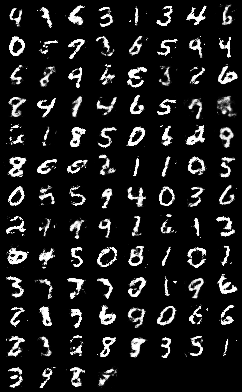

In [4]:
Image(data = 'F:/ACV/TERM WORK/gan/WGAN-GP/samples/fake_images-188.png', width = 400)

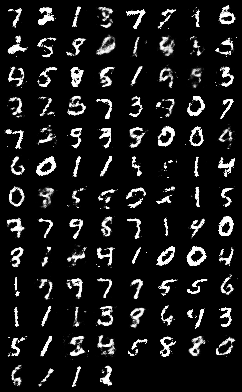

In [6]:
Image(data = 'F:/ACV/TERM WORK/gan/WGAN-GP/samples/fake_images-197.png', width = 400)

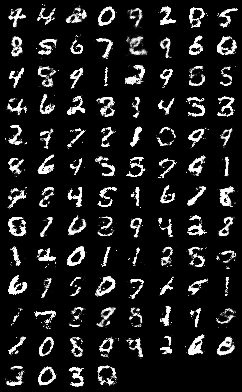

In [5]:
Image(data = 'F:/ACV/TERM WORK/gan/WGAN-GP/samples/fake_images-200.png', width = 400)